In [1]:
# set seed for reproducibility
import torch
torch.manual_seed(42)

In [2]:
import os
import uproot
import numpy as np

def load_root_file(file_path, branches=None, print_branches=False):
    all_branches = {}
    with uproot.open(file_path) as file:
        tree = file["tree"]
        # Load all ROOT branches into array if not specified
        if branches is None:
            branches = tree.keys()
        # Option to print the branch names
        if print_branches:
            print("Branches:", tree.keys())
        # Each branch is added to the dictionary
        for branch in branches:
            try:
                all_branches[branch] = (tree[branch].array(library="np"))
            except uproot.KeyInFileError as e:
                print(f"KeyInFileError: {e}")
        # Number of events in file
        all_branches['event'] = tree.num_entries
    return all_branches

branches_list = [
    't5_innerRadius',
    't5_bridgeRadius',
    't5_outerRadius',
    't5_pt',
    't5_eta',
    't5_phi',
    't5_isFake',
    't5_t3_idx0',
    't5_t3_idx1',
    't5_t3_fakeScore1',
    't5_t3_promptScore1',
    't5_t3_displacedScore1',
    't5_t3_fakeScore2',
    't5_t3_promptScore2',
    't5_t3_displacedScore2',
    't5_pMatched',
    't5_sim_vxy',
    't5_sim_vz',
    't5_matched_simIdx'
]


# Hit-dependent branches
suffixes = ['r', 'z', 'eta', 'phi', 'layer']
branches_list += [f't5_t3_{i}_{suffix}' for i in [0, 2, 4] for suffix in suffixes]

file_path = "t5_dnn_500.root"
branches = load_root_file(file_path, branches_list)

In [3]:
z_max = np.max([np.max(event) for event in branches[f't5_t3_4_z']])
r_max = np.max([np.max(event) for event in branches[f't5_t3_4_r']])
eta_max = 2.5
phi_max = np.pi

print(f'Z max: {z_max}, R max: {r_max}, Eta max: {eta_max}')

def delta_phi(phi1, phi2):
    delta = phi1 - phi2
    # Adjust delta to be within the range [-pi, pi]
    if delta > np.pi:
        delta -= 2 * np.pi
    elif delta < -np.pi:
        delta += 2 * np.pi
    return delta

Z max: 267.2349853515625, R max: 110.10993957519531, Eta max: 2.5


In [ ]:
features_list = []
eta_list = [] # Used for DNN cut values

for ev in range(branches['event']):
    # Determine the number of elements in this event
    num_elements = len(branches['t5_t3_idx0'][ev])

    for i in range(num_elements):
        features_iter = []
        eta_iter = []
        
        idx0 = branches['t5_t3_idx0'][ev][i]
        idx1 = branches['t5_t3_idx1'][ev][i]

        # hit-level quantities -------------------------------------------------
        eta1 = abs(branches['t5_t3_0_eta'][ev][idx0])
        eta2 = abs(branches['t5_t3_2_eta'][ev][idx0])
        eta3 = abs(branches['t5_t3_4_eta'][ev][idx0])
        eta4 = abs(branches['t5_t3_2_eta'][ev][idx1])
        eta5 = abs(branches['t5_t3_4_eta'][ev][idx1])

        phi1 = branches['t5_t3_0_phi'][ev][idx0]
        phi2 = branches['t5_t3_2_phi'][ev][idx0]
        phi3 = branches['t5_t3_4_phi'][ev][idx0]
        phi4 = branches['t5_t3_2_phi'][ev][idx1]
        phi5 = branches['t5_t3_4_phi'][ev][idx1]

        z1 = abs(branches['t5_t3_0_z'][ev][idx0])
        z2 = abs(branches['t5_t3_2_z'][ev][idx0])
        z3 = abs(branches['t5_t3_4_z'][ev][idx0])
        z4 = abs(branches['t5_t3_2_z'][ev][idx1])
        z5 = abs(branches['t5_t3_4_z'][ev][idx1])

        r1 = branches['t5_t3_0_r'][ev][idx0]
        r2 = branches['t5_t3_2_r'][ev][idx0]
        r3 = branches['t5_t3_4_r'][ev][idx0]
        r4 = branches['t5_t3_2_r'][ev][idx1]
        r5 = branches['t5_t3_4_r'][ev][idx1]

        inR  = branches['t5_innerRadius' ][ev][i]
        brR  = branches['t5_bridgeRadius'][ev][i]
        outR = branches['t5_outerRadius' ][ev][i]

        s1_fake   = branches['t5_t3_fakeScore1'     ][ev][i]
        s1_prompt = branches['t5_t3_promptScore1'   ][ev][i]
        s1_disp   = branches['t5_t3_displacedScore1'][ev][i]
        d_fake    = branches['t5_t3_fakeScore2'     ][ev][i] - s1_fake
        d_prompt  = branches['t5_t3_promptScore2'   ][ev][i] - s1_prompt
        d_disp    = branches['t5_t3_displacedScore2'][ev][i] - s1_disp

        # Construct the input feature vector using pairwise differences
        features_iter = [
            eta1 / eta_max,
            np.cos(phi1),
            np.sin(phi1),
            z1 / z_max,
            r1 / r_max,

            eta2 - eta1,
            delta_phi(phi2, phi1),
            (z2 - z1) / z_max,
            (r2 - r1) / r_max,

            eta3 - eta2,
            delta_phi(phi3, phi2),
            (z3 - z2) / z_max,
            (r3 - r2) / r_max,

            eta4 - eta3,
            delta_phi(phi4, phi3),
            (z4 - z3) / z_max,
            (r4 - r3) / r_max,

            eta5 - eta4,
            delta_phi(phi5, phi4),
            (z5 - z4) / z_max,
            (r5 - r4) / r_max,

            1.0 / inR,
            1.0 / brR,
            1.0 / outR,

            s1_fake, s1_prompt, s1_disp,
            d_fake,  d_prompt,  d_disp
        ]

        # Use the abs eta value of first hit to select cut thresholds
        eta_iter.extend([np.abs(branches['t5_t3_0_eta'][ev][idx0])])
        
        # Append the feature vector to the list
        features_list.append(features_iter)
        eta_list.append(eta_iter)

# Convert the list of features to a NumPy array
features = np.array(features_list).T
eta_list = np.array(eta_list).T

In [5]:
import torch

# Stack features along a new axis to form a single array suitable for NN input
input_features_numpy = np.stack(features, axis=-1)

# Identify rows with NaN or Inf values
mask = ~np.isnan(input_features_numpy) & ~np.isinf(input_features_numpy)

# Apply mask across all columns: retain a row only if all its entries are neither NaN nor Inf
filtered_input_features_numpy = input_features_numpy[np.all(mask, axis=1)]
t5_isFake_filtered = np.concatenate(branches['t5_isFake'])[np.all(mask, axis=1)]

# Convert to PyTorch tensor when ready to use with NN
input_features_tensor = torch.tensor(filtered_input_features_numpy, dtype=torch.float32)

In [6]:
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create labels tensor
labels_tensor = 1 - torch.tensor(t5_isFake_filtered, dtype=torch.float32)

# Set initial downsample fraction
initial_downsample_fraction = 1.0  # Adjust this value as needed

class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features_numpy.shape[1], 32)
        self.layer2 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x

class WeightedBCELoss(nn.Module):
    def __init__(self):
        super(WeightedBCELoss, self).__init__()
        
    def forward(self, outputs, targets, weights):
        eps = 1e-7
        losses = -(weights * (targets * torch.log(outputs + eps) + 
                            (1 - targets) * torch.log(1 - outputs + eps)))
        return losses.mean()

def calculate_sample_weights(t5_sim_vxy, weight_factor=6.0):
    """
    Calculate sample weights giving higher importance to displaced t5's
    
    Args:
        t5_sim_vxy: Array of t5 simulation values
        weight_factor: How much more weight to give to displaced samples
    
    Returns:
        Tensor of sample weights
    """
    weights = torch.ones(len(t5_sim_vxy))
    displaced_mask = t5_sim_vxy > 0.1
    weights[displaced_mask] = weight_factor
    return weights

# Print initial dataset size
print(f"Initial dataset size: {len(labels_tensor)}")

# Calculate sample weights
sample_weights = calculate_sample_weights(torch.tensor(np.concatenate(branches['t5_sim_vxy'])))

# Remove rows with NaN and update weights accordingly
nan_mask = torch.isnan(input_features_tensor).any(dim=1) | torch.isnan(labels_tensor)
filtered_inputs = input_features_tensor[~nan_mask]
filtered_labels = labels_tensor[~nan_mask]
filtered_weights = sample_weights[~nan_mask]

# Initial downsampling of entire dataset
if initial_downsample_fraction < 1.0:
    total_samples = len(filtered_labels)
    samples_to_keep = int(total_samples * initial_downsample_fraction)
    indices = torch.randperm(total_samples)[:samples_to_keep]
    filtered_inputs = filtered_inputs[indices]
    filtered_labels = filtered_labels[indices]
    filtered_weights = filtered_weights[indices]

print(f"Dataset size after initial {initial_downsample_fraction*100}% downsampling: {len(filtered_labels)}")

# Count samples in each class after initial downsampling
class_counts = torch.bincount(filtered_labels.int())
print(f"Class distribution after initial downsampling - Class 0: {class_counts[0]}, Class 1: {class_counts[1]}")

# Balance classes while maintaining weights
minority_class = 0 if class_counts[0] < class_counts[1] else 1
minority_indices = (filtered_labels == minority_class).nonzero(as_tuple=True)[0]
majority_indices = (filtered_labels == (1 - minority_class)).nonzero(as_tuple=True)[0]
downsampled_majority_indices = majority_indices[torch.randperm(len(majority_indices))[:len(minority_indices)]]
balanced_indices = torch.cat((minority_indices, downsampled_majority_indices))

# Create balanced dataset with weights
balanced_inputs = filtered_inputs[balanced_indices]
balanced_labels = filtered_labels[balanced_indices]
balanced_weights = filtered_weights[balanced_indices]

# Verify balanced distribution
balanced_counts = torch.bincount(balanced_labels.int())
print(f"Final class distribution after balancing - Class 0: {balanced_counts[0]}, Class 1: {balanced_counts[1]}")

# Create dataset with weights
dataset = TensorDataset(balanced_inputs, balanced_labels, balanced_weights)

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=10, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=10, pin_memory=True)

# Initialize model and optimizer
model = MyNeuralNetwork().to(device)
loss_function = WeightedBCELoss()
optimizer = Adam(model.parameters(), lr=0.0025)

def evaluate_model(loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, targets, weights in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predicted = outputs.squeeze() > 0.5
            total += targets.size(0)
            correct += (predicted == targets.bool()).sum().item()
    model.train()
    return 100 * correct / total

# Training loop
num_epochs = 150
loss_log = []

for epoch in range(num_epochs):
    for inputs, targets, weights in train_loader:
        inputs, targets, weights = inputs.to(device), targets.to(device), weights.to(device)
    
        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs.squeeze(), targets, weights)
        
        loss_log.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    test_accuracy = evaluate_model(test_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Acc: {test_accuracy:.2f}%')

Using device: cuda
Initial dataset size: 5204111
Dataset size after initial 100.0% downsampling: 5204111
Class distribution after initial downsampling - Class 0: 1244812, Class 1: 3959299
Final class distribution after balancing - Class 0: 1244812, Class 1: 1244812
Epoch [1/150], Loss: 0.3638, Test Acc: 78.94%
Epoch [2/150], Loss: 0.6978, Test Acc: 75.90%
Epoch [3/150], Loss: 0.3357, Test Acc: 79.65%
Epoch [4/150], Loss: 0.3070, Test Acc: 79.73%
Epoch [5/150], Loss: 0.4405, Test Acc: 78.41%
Epoch [6/150], Loss: 0.4811, Test Acc: 79.48%
Epoch [7/150], Loss: 0.6131, Test Acc: 78.46%
Epoch [8/150], Loss: 0.7887, Test Acc: 81.24%
Epoch [9/150], Loss: 0.3864, Test Acc: 79.71%
Epoch [10/150], Loss: 0.5488, Test Acc: 81.37%
Epoch [11/150], Loss: 0.5781, Test Acc: 81.29%
Epoch [12/150], Loss: 0.4789, Test Acc: 82.55%
Epoch [13/150], Loss: 0.5407, Test Acc: 82.06%
Epoch [14/150], Loss: 0.5605, Test Acc: 81.95%
Epoch [15/150], Loss: 0.5691, Test Acc: 82.80%
Epoch [16/150], Loss: 2.0158, Test Acc

In [7]:
torch.save(model.state_dict(), "model.pth")

In [8]:
from sklearn.metrics import accuracy_score

# Convert tensors to numpy for simplicity in permutation
input_features_np = input_features_tensor.numpy()
labels_np = labels_tensor.numpy()

def model_accuracy(features, labels, model):
    model.eval()  # Set the model to evaluation mode
    inputs = features.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()  # Update threshold as necessary
        accuracy = (predicted == labels).float().mean().item()
    return accuracy

# Use the original input_features_tensor and labels_tensor directly
baseline_accuracy = model_accuracy(input_features_tensor, labels_tensor, model)
print(f"Baseline accuracy: {baseline_accuracy}")

# Initialize an array to store feature importances
feature_importances = np.zeros(input_features_tensor.shape[1])

# Permute each feature and calculate the drop in accuracy
for i in range(input_features_tensor.shape[1]):
    permuted_features = input_features_tensor.clone()
    permuted_features[:, i] = permuted_features[torch.randperm(permuted_features.size(0)), i]  # Permute feature

    permuted_accuracy = model_accuracy(permuted_features, labels_tensor, model)
    feature_importances[i] = baseline_accuracy - permuted_accuracy

# Ranking features by importance
important_features_indices = np.argsort(feature_importances)[::-1]  # Indices of features in descending importance
important_features_scores = np.sort(feature_importances)[::-1]  # Importance scores in descending order

print("Feature importances:")
for idx, score in zip(important_features_indices, important_features_scores):
    print(f"Feature {idx} importance: {score:.4f}")

Baseline accuracy: 0.884520947933197
Feature importances:
Feature 22 importance: 0.3675
Feature 21 importance: 0.3299
Feature 13 importance: 0.1474
Feature 24 importance: 0.1118
Feature 3 importance: 0.0704
Feature 25 importance: 0.0614
Feature 9 importance: 0.0598
Feature 0 importance: 0.0477
Feature 16 importance: 0.0385
Feature 28 importance: 0.0377
Feature 26 importance: 0.0369
Feature 5 importance: 0.0296
Feature 27 importance: 0.0259
Feature 17 importance: 0.0259
Feature 4 importance: 0.0200
Feature 23 importance: 0.0200
Feature 15 importance: 0.0142
Feature 11 importance: 0.0139
Feature 29 importance: 0.0126
Feature 19 importance: 0.0105
Feature 12 importance: 0.0084
Feature 7 importance: 0.0051
Feature 8 importance: 0.0042
Feature 20 importance: 0.0024
Feature 10 importance: 0.0016
Feature 6 importance: 0.0010
Feature 18 importance: 0.0009
Feature 14 importance: 0.0005
Feature 2 importance: 0.0002
Feature 1 importance: 0.0001


/tmp/ipykernel_4048610/52354147.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(features, dtype=torch.float32).to(device)


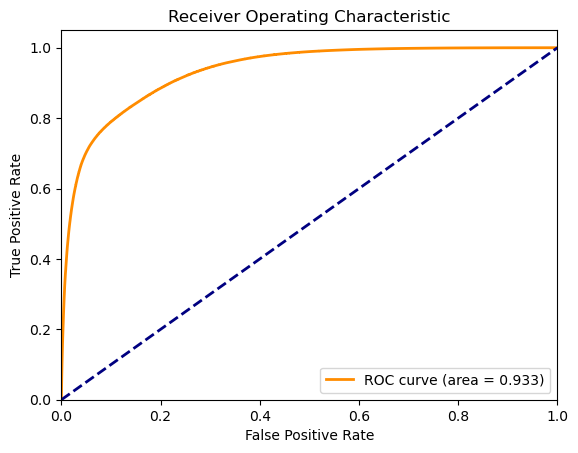

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def model_outputs(features, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        inputs = torch.tensor(features, dtype=torch.float32).to(device)
        outputs = model(inputs).squeeze().cpu().numpy()
    return outputs

# Calculate model outputs
probabilities = model_outputs(filtered_inputs, model)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(filtered_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

/tmp/ipykernel_4048610/52354147.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(features, dtype=torch.float32).to(device)


Prediction scores for displaced tracks (t5_sim_vxy > 0.1):
Mean score: 0.8407
Median score: 0.9375


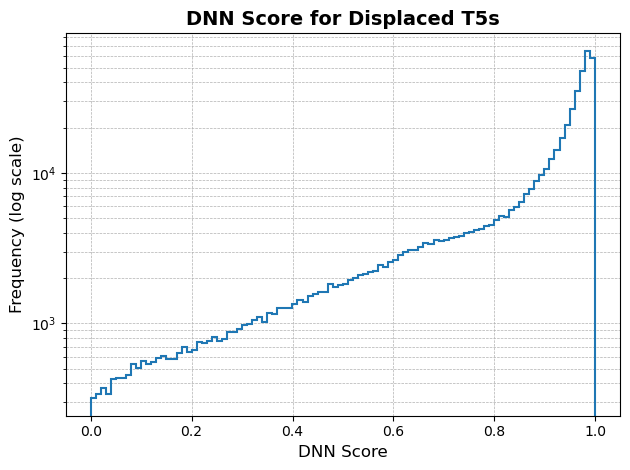

In [10]:
# Get model predictions
probabilities = model_outputs(filtered_inputs, model)

# Get displaced track mask
displaced_mask = np.concatenate(branches['t5_sim_vxy'])[~nan_mask] > 0.1

# Calculate statistics for displaced tracks
displaced_predictions = probabilities[displaced_mask]
mean_score = np.mean(displaced_predictions)
median_score = np.median(displaced_predictions)

print(f"Prediction scores for displaced tracks (t5_sim_vxy > 0.1):")
print(f"Mean score: {mean_score:.4f}")
print(f"Median score: {median_score:.4f}")

plt.hist(displaced_predictions, bins=100, histtype='step', linewidth=1.5)  # Outline only, no fill
plt.yscale('log')
plt.xlabel("DNN Score", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("DNN Score for Displaced T5s", fontsize=14, weight='bold')

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [11]:
def print_formatted_weights_biases(weights, biases, layer_name):
    # Print biases
    print(f"HOST_DEVICE_CONSTANT float bias_{layer_name}[{len(biases)}] = {{")
    print(", ".join(f"{b:.7f}f" for b in biases) + " };")
    print()

    # Print weights
    print(f"HOST_DEVICE_CONSTANT float wgtT_{layer_name}[{len(weights[0])}][{len(weights)}] = {{")
    for row in weights.T:
        formatted_row = ", ".join(f"{w:.7f}f" for w in row)
        print(f"{{ {formatted_row} }},")
    print("};")
    print()

def print_model_weights_biases(model):
    # Make sure the model is in evaluation mode
    model.eval()

    # Iterate through all named modules in the model
    for name, module in model.named_modules():
        # Check if the module is a linear layer
        if isinstance(module, nn.Linear):
            # Get weights and biases
            weights = module.weight.data.cpu().numpy()
            biases = module.bias.data.cpu().numpy()

            # Print formatted weights and biases
            print_formatted_weights_biases(weights, biases, name.replace('.', '_'))

print_model_weights_biases(model)


HOST_DEVICE_CONSTANT float bias_layer1[32] = {
0.1063484f, -0.2586785f, -0.4041654f, 0.2874144f, -0.0048153f, -0.0552224f, -0.3353412f, -0.1217787f, -0.1023233f, -0.4895379f, 0.0724831f, -0.0782305f, 0.0423554f, -0.3448199f, 0.7893330f, 0.5417718f, -0.3814211f, -0.0300061f, -0.0872166f, 0.0745094f, -0.0508228f, 0.0263381f, 0.2278053f, 0.0868638f, -0.1107799f, -0.0413309f, -0.1491974f, -0.1661576f, -0.4162534f, 0.4993950f, 0.0897595f, -0.5779333f };

HOST_DEVICE_CONSTANT float wgtT_layer1[30][32] = {
{ -0.1505160f, -0.6940249f, 0.4992728f, -0.7896332f, -0.0977756f, 0.3208770f, -0.2162933f, -0.0716252f, 0.0234017f, -0.0250481f, -0.4447506f, 0.0850351f, -0.5346628f, 0.3859509f, 0.1076398f, -0.0121937f, 0.5085616f, 0.3470633f, 0.5595261f, 0.4235995f, 0.3145484f, -0.6091570f, 0.0361726f, -0.6665804f, 0.0232229f, 1.4018483f, -0.1372670f, -0.1640743f, 0.1404200f, 0.1181919f, -0.0184279f, 0.6332238f },
{ 0.0081468f, -0.0151515f, -0.0168529f, 0.0027244f, 0.0022829f, -0.0126172f, 0.0208032f, -0.

In [12]:
# Ensure input_features_tensor is moved to the appropriate device
input_features_tensor = input_features_tensor.to(device)

# Make predictions
with torch.no_grad():
    model.eval()
    outputs = model(input_features_tensor)
    predictions = outputs.squeeze().cpu().numpy()

full_tracks = (np.concatenate(branches['t5_isFake']) == 0) * (np.concatenate(branches['t5_pMatched']) > 0.95)

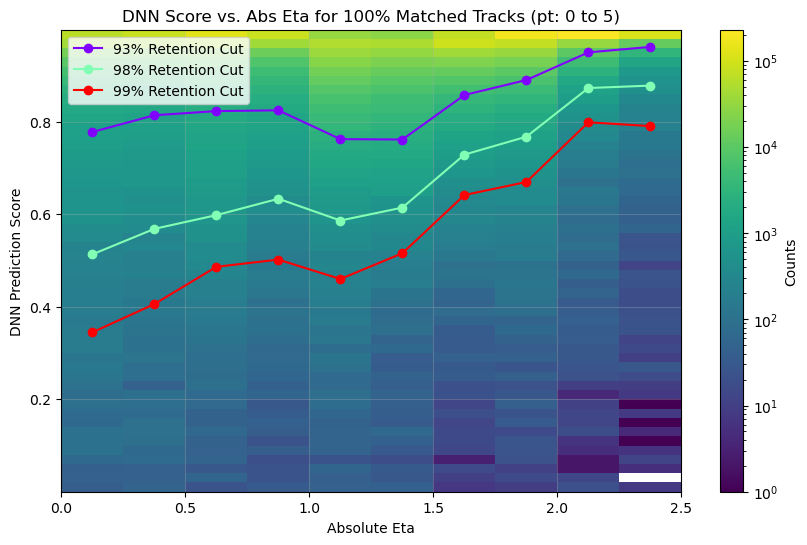


pt: 0 to 5
93% Retention Cut: {0.7782f, 0.8144f, 0.8234f, 0.8251f, 0.7628f, 0.7619f, 0.8582f, 0.8906f, 0.9504f, 0.9623f} Mean: 0.8427
98% Retention Cut: {0.5136f, 0.5687f, 0.5984f, 0.6338f, 0.5867f, 0.6147f, 0.7293f, 0.768f, 0.8734f, 0.8785f} Mean: 0.6765
99% Retention Cut: {0.3449f, 0.406f, 0.4866f, 0.5022f, 0.4603f, 0.516f, 0.6418f, 0.6701f, 0.7992f, 0.791f} Mean: 0.5618


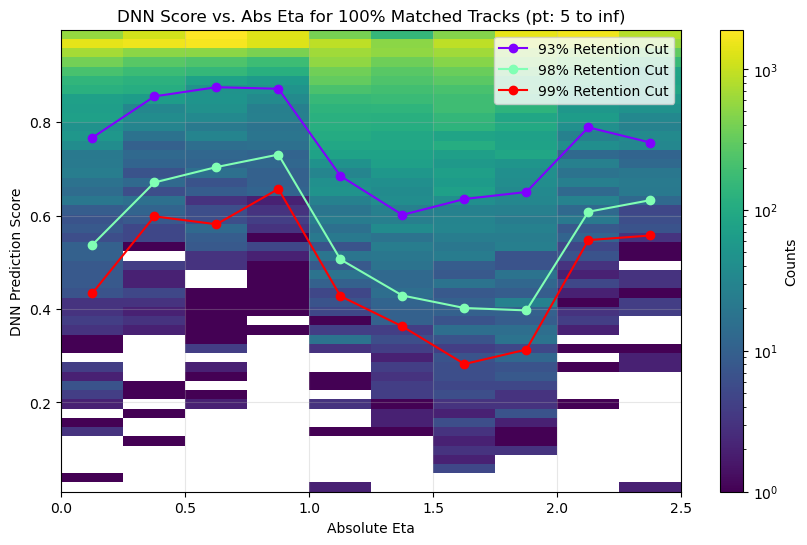


pt: 5 to inf
93% Retention Cut: {0.7673f, 0.8557f, 0.8754f, 0.872f, 0.6853f, 0.6018f, 0.6358f, 0.6508f, 0.7893f, 0.7568f} Mean: 0.749
98% Retention Cut: {0.5378f, 0.6712f, 0.7042f, 0.7311f, 0.5064f, 0.429f, 0.4023f, 0.3971f, 0.6085f, 0.6333f} Mean: 0.5621
99% Retention Cut: {0.4341f, 0.5986f, 0.5817f, 0.6574f, 0.4278f, 0.3627f, 0.2822f, 0.3132f, 0.5478f, 0.5576f} Mean: 0.4763


In [13]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

def plot_for_pt_bin(pt_min, pt_max, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches):
    """
    Calculate and plot cut values for specified percentiles in a given pt bin
    
    Parameters:
    -----------
    pt_min : float
        Minimum pt value for the bin
    pt_max : float
        Maximum pt value for the bin
    percentiles : list
        List of percentiles to calculate (e.g., [92.5, 96.7, 99])
    eta_bin_edges : array
        Edges of the eta bins
    eta_list : list
        List of eta values
    predictions : array
        Array of DNN predictions
    full_tracks : array
        Boolean array for track selection
    branches : dict
        Dictionary containing branch data
    """
    # Filter data based on pt bin
    abs_eta = eta_list[0][full_tracks & (np.concatenate(branches['t5_pt']) > pt_min) & 
                         (np.concatenate(branches['t5_pt']) <= pt_max)]
    predictions_filtered = predictions[full_tracks & (np.concatenate(branches['t5_pt']) > pt_min) & 
                                    (np.concatenate(branches['t5_pt']) <= pt_max)]
    
    # Dictionary to store cut values for different percentiles
    cut_values = {p: [] for p in percentiles}

    # Loop through each eta bin
    for i in range(len(eta_bin_edges) - 1):
        # Get indices of tracks within the current eta bin
        bin_indices = (abs_eta >= eta_bin_edges[i]) & (abs_eta < eta_bin_edges[i + 1])
        
        # Get the corresponding DNN prediction scores
        bin_predictions = predictions_filtered[bin_indices]
        
        # Calculate the percentile cut values for the current bin
        for percentile in percentiles:
            cut_value = np.percentile(bin_predictions, 100 - percentile)  # Convert retention to percentile
            cut_values[percentile].append(cut_value)

    # Plot 2D histogram
    plt.figure(figsize=(10, 6))
    plt.hist2d(abs_eta, predictions_filtered, bins=[eta_bin_edges, 50], norm=LogNorm())
    plt.colorbar(label='Counts')
    plt.xlabel("Absolute Eta")
    plt.ylabel("DNN Prediction Score")
    plt.title(f"DNN Score vs. Abs Eta for 100% Matched Tracks (pt: {pt_min} to {pt_max})")

    # Plot the cut values with different colors
    cut_x = eta_bin_edges[:-1] + (eta_bin_edges[1] - eta_bin_edges[0]) / 2  # Mid-points of the bins
    colors = plt.cm.rainbow(np.linspace(0, 1, len(percentiles)))  # Generate distinct colors
    
    for percentile, color in zip(percentiles, colors):
        plt.plot(cut_x, cut_values[percentile], '-', color=color, marker='o', 
                label=f'{percentile}% Retention Cut')
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print the cut values
    print(f"\npt: {pt_min} to {pt_max}")
    for percentile in percentiles:
        values = cut_values[percentile]
        print(f"{percentile}% Retention Cut:", 
              '{' + ', '.join(str(x) + 'f' for x in np.round(values, 4)) + '}',
              "Mean:", np.round(np.mean(values), 4))

# Example usage:
def analyze_pt_bins(pt_bins, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches):
    """
    Analyze and plot for multiple pt bins and percentiles
    
    Parameters:
    -----------
    pt_bins : list
        List of pt bin edges
    percentiles : list
        List of percentiles to calculate
    Other parameters same as plot_for_pt_bin function
    """
    for i in range(len(pt_bins) - 1):
        plot_for_pt_bin(pt_bins[i], pt_bins[i + 1], percentiles, eta_bin_edges, 
                       eta_list, predictions, full_tracks, branches)

# Example call:
percentiles = [93, 98, 99]
pt_bins = [0, 5, np.inf]
eta_bin_edges = np.arange(0, 2.75, 0.25)
analyze_pt_bins(pt_bins, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches)